In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [14]:
def clear_data(path: str):
    try:
        # Read the data
        data = pd.read_csv(path)
        # if a line contains "null" or "NaN" remove the line
        data = data[~data['Open'].isin(['null', 'NaN'])]
        # save the data
        data.to_csv(path, index=False)
        print("Data cleared")
    except:
        print("Data not cleared")
    
def import_data(daily_path: str, divident_path: str):
    clear_data(daily_path)
    daily_data = pd.read_csv(daily_path)
    # Skip days where volume is 0
    daily_data = daily_data[daily_data['Volume'] != 0]
    # Skip days where open is 0
    daily_data = daily_data[daily_data['Open'] != 0]
    # Drop na
    daily_data = daily_data.dropna()
    if divident_path != None:
        clear_data(divident_path)
        divident_data = pd.read_csv(divident_path)
        # Remove the divident dates from the daily data
        daily_data = daily_data[~daily_data['Date'].isin(divident_data['Date'])]
    # Calculate the percentage difference
    daily_data['OpenCloseDiff'] = (-daily_data['Open'].shift(1) + daily_data['Open']) / daily_data['Open']
    # Remove the differences bigger than 20%
    daily_data = daily_data[daily_data['OpenCloseDiff'] < 0.2]
    daily_data = daily_data[daily_data['OpenCloseDiff'] > -0.2]
    
    # Multiply by 100 to get percentage
    daily_data['OpenCloseDiff'] = daily_data['OpenCloseDiff'] * 100
    # Return the percentage difference
    return daily_data['OpenCloseDiff']

def plot_histogram(data: dict):
    # Clear the plot
    plt.clf()
    # Plot the histograms as a line
    for key in data.keys():
        plt.hist(data[key], bins='auto', alpha=0.5, label=key, density=True)
    # Set the title and labels
    plt.title('Daily Percentage Difference Histogram')
    plt.xlabel('Percentage Difference')
    plt.ylabel('Frequency')
    # Show the legend
    plt.legend()
    # Show the plot
    plt.show()

def calculate_covariance_matrix(data: dict):

    # Clear the plot
    plt.clf()
    # Create a dataframe for the data
    df = pd.DataFrame(data)
    # Send market to the front
    df = df[['BIST'] + [col for col in df.columns if col != 'BIST']]
    # Calculate the covariance matrix
    cov = df.cov()
    # Plot the covariance matrix
    sns.heatmap(cov, annot=True)
    # Set the title
    plt.title('Covariance Matrix')
    # Show the plot
    plt.show()
    # Return the covariance matrix
    return cov

def calculate_efficient_frontier(data: dict, stock_names: list, do_plot: bool = True):
    # Clear the plot
    plt.clf()
    # Get the mean of first stock
    mean1 = data[list(data.keys())[0]].mean()
    # Get the mean of second stock
    mean2 = data[list(data.keys())[1]].mean()
    # Get the standard deviation of first stock
    std1 = data[list(data.keys())[0]].std()
    # Get the standard deviation of second stock
    std2 = data[list(data.keys())[1]].std()
    # Get the covariance of the two stocks
    cov = data[list(data.keys())[0]].cov(data[list(data.keys())[1]])
    # Create a dictionary
    dict_list = []
    # Create a list of weights
    weights = np.linspace(0, 1, 100)
    # For each weight
    for weight in weights:
        # Calculate the return
        ret = (weight * mean1) + ((1 - weight) * mean2)
        # Calculate the standard deviation
        std = np.sqrt((weight ** 2) * (std1 ** 2) + ((1 - weight) ** 2) * (std2 ** 2) + 2 * weight * (1 - weight) * cov)
        # Append the dictionary
        dict_list.append({'return': ret, 'std': std})


    if do_plot:
    # Plot the dictionary and change the color
        for i in range(len(dict_list) - 1):
            plt.plot([dict_list[i]['std'], dict_list[i + 1]['std']], [dict_list[i]['return'], dict_list[i + 1]['return']],
                    color=plt.cm.viridis(weights[i]))

        # annotate the plot with numbers from 1 to 100 and skip every 5
        for i in range(0, 100, 33):
            annotation_name = stock_names[0] + ': ' + str(i) + '%, ' + stock_names[1] + ': ' + str(100 - i) + '%'
            plt.annotate(annotation_name, (dict_list[i]['std'], dict_list[i]['return']))

        # Mark the point with highest sharpe ratio and annotate its index
        max_sharpe = max(dict_list, key=lambda x: x['return'] / x['std'])
        plt.scatter(max_sharpe['std'], max_sharpe['return'], marker='x', color='red', s=200)
        
        # Find the index of the max sharpe ratio
        index = dict_list.index(max_sharpe)
        # Annotate the index
        annotation_name = stock_names[0] + ': ' + str(index) + '%, ' + stock_names[1] + ': ' + str(100 - index) + '%'
        plt.annotate(annotation_name, (dict_list[index]['std'], dict_list[index]['return']))
        
        

        # Set the title from stock_names
        plt.title('Efficient Frontier for ' + stock_names[0] + ' and ' + stock_names[1])
        # Set the labels
        plt.xlabel('Standard Deviation')
        plt.ylabel('Return')
        # Show the plot
        plt.show()
        # Clear the plot
    plt.clf()
    # Return the dictionary
    return dict_list

def calculate_efficient_frontier_for_multiple_assets(data: dict, stock_names: list, weight_increment: int = 5, do_plot: bool = True, risk_parameter: float = 1):

    # Clear the plot
    plt.clf()
    # Import to a dataframe
    df = pd.DataFrame(data)
    # Calculate the covariance matrix
    cov = df.cov()
    # Calculate the mean
    mean = df.mean()
    # List of returns and standard deviations with weights
    ret_list = []
    # Counter for statistic purposes
    count = 0

    # Iterate over the possible portfolios with 5 assets and 5% increments
    for i in range(0, 100, weight_increment):
        for j in range(i, 100 - i, weight_increment):
            for k in range(j, 100 - i - j, weight_increment):
                for l in range(k, 100 - i - j - k, weight_increment):
                    # Calculate the last weight
                    m = 100 - i - j - k - l
                    # Calculate the weights
                    weights = [i, j, k, l, m]
                    # Calculate the return
                    ret = np.dot(weights, mean)
                    # Calculate the standard deviation
                    std = np.sqrt(np.dot(weights, np.dot(cov, weights)))
                    # Exponentiate std with risk parameter
                    std = np.power(std, risk_parameter)
                    # Plot the return and standard deviation
                    plt.scatter(std, ret, color='blue')
                    # Append the dictionary
                    ret_list.append({'return': ret, 'std': std, 'weights': weights})
                    count += 1


    # Set the title
    plt.title('Efficient Frontier for ' + str(stock_names))
    # Set the labels
    plt.xlabel('Standard Deviation')
    plt.ylabel('Return')
    # Show the plot
    plt.show()
    # Clear the plot
    plt.clf()
    # print count
    print(count)
    # Return the dictionary
    return ret_list
    

In [ ]:
# An API to get data from Yahoo Finance
def get_data_from_yahoo(tickers: list, start_date: str, end_date: str):
    # Import the data
    data = pd.DataFrame()
    for ticker in tickers:
        data[ticker] = wb.DataReader(ticker, data_source='yahoo', start=start_date, end=end_date)['Adj Close']
    # Return the data
    return data

In [15]:
def main(): #color=plt.cm.viridis(weights[i])
    # List the paths in "/dataset"
    paths = os.listdir('dataset')
    values = {}
    for path in paths:
        # List the files in the path
        files = os.listdir('dataset/' + path)
        # Create the paths
        daily_path = 'dataset/' + path + '/daily.csv'
        # If there is a divident file, add it to the path
        divident_path = 'dataset/' + path + '/divident.csv' if 'divident.csv' in files else None
        # Import the data
        data = import_data(daily_path, divident_path)
        # Add the data to the dictionary
        values.update({path: data})
    # Calculate the efficient frontier
    efficient_frontier = calculate_efficient_frontier_for_multiple_assets(values, paths, 4, True, 0.5)
    # Print the time
    print(end - start)
    # Pick the portfolio with the highest sharpe ratio
    max_sharpe = max(efficient_frontier, key=lambda x: x['return'] / x['std'])
    # Print the portfolio
    print(max_sharpe)

Data cleared
Data not cleared
Data cleared
Data not cleared
Data cleared
Data cleared
Data not cleared
Data cleared
Data not cleared


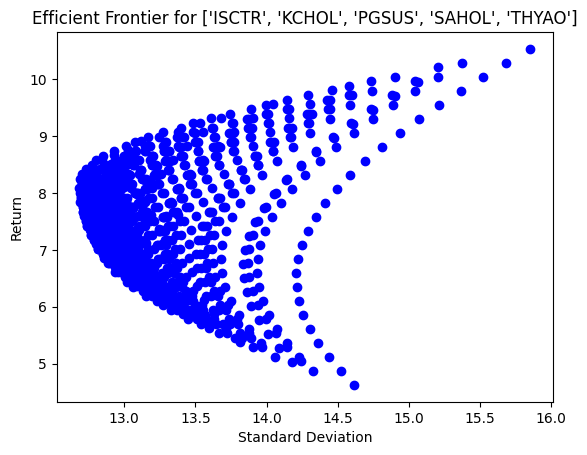

1292
11.37834095954895
{'return': 9.224520918768112, 'std': 13.483036380516834, 'weights': [0, 16, 16, 16, 52]}


<Figure size 640x480 with 0 Axes>

In [16]:
main()